# PolyaClassifier predictions on external data

**Purpose**: To corroborate PolyaClassifier predictions in *S. cerevisiae* using non-3'READS data.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import models

In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyaclassifier_external_corroboration')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
boxplot_format = {
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

barplot_format = {
    'color'     : 'lightgray',
    'edgecolor' : 'black',
    'linewidth' : 0.5
}

## ANALYSIS

### Pooled 3'READS used for model development

In [7]:
reads3_data = pd.read_csv(os.path.join(PROJECT, "saccharomyces_cerevisiae/data/data_preparation/relative_usage/redistA.no_clustered.wild_type.tf_0.00.ru_0.02.reads_10.clusters_rudesc_alltissue.txt"), sep = "\t")
print(reads3_data.shape)


(1480332, 6)


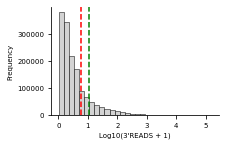

Corresponding thresholds:
Pooled 3'READS >= 5 :  349,404 (23.60%)
Pooled 3'READS >= 10:  220,768 (14.91%)


In [8]:
fig,ax = plt.subplots(1,1, figsize = (3,2))

ax.hist(np.log10(reads3_data['reads_overall']+1), bins = 30, **barplot_format)

ax.axvline(x = np.log10(5+1), color = 'red', linestyle = 'dashed')
ax.axvline(x = np.log10(10+1), color = 'green', linestyle = 'dashed')

ax.set_xlabel("Log10(3'READS + 1)")
ax.set_ylabel("Frequency")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("Corresponding thresholds:")
print(f"Pooled 3'READS >= 5 : {(reads3_data['reads_overall'] >= 5).sum():8,d} ({(reads3_data['reads_overall'] >= 5).astype(int).mean():.02%})", )
print(f"Pooled 3'READS >= 10: {(reads3_data['reads_overall'] >= 10).sum():8,d} ({(reads3_data['reads_overall'] >= 10).astype(int).mean():.02%})", )


In [9]:
reads3_test_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_cross_species_predictions.scer_test_data_12345.pred_by_scer_bagging3models.txt'), sep = "\t")
test_genes = reads3_test_data['gene'].unique().tolist()
print(f"Input sites:\n\t{reads3_test_data.shape[0]}, genes={len(test_genes)}")

reads3_test_data.loc[reads3_test_data['supporting_reads'] >  0, 'obs_class'] = 1
reads3_test_data.loc[reads3_test_data['supporting_reads'] == 0, 'obs_class'] = 0
print(f"By class:\n\t{reads3_test_data['obs_class'].value_counts().to_dict()}")


Input sites:
	8047, genes=8047
By class:
	{1.0: 4046, 0.0: 4001}


In [10]:
reads3_auroc, reads3_auprc = models.calculate_auc(reads3_test_data['obs_class'], reads3_test_data['classification'])
print(f"Performance:\n\tAUROC={reads3_auroc:.06f}\n\tAUPRC={reads3_auprc:.06f}")


Performance:
	AUROC=0.989145
	AUPRC=0.989672


### 3P-seq data from Dave Bartel's lab

In [11]:
p3seq_data = pd.read_csv(os.path.join(PROJECT, "saccharomyces_cerevisiae_3Pseq/data/data_preparation/relative_usage/redistA.no_clustered.wild_type.tf_0.00.ru_0.02.reads_10.clusters_rudesc_alltissue.txt"), sep = "\t")
print(p3seq_data.shape)


(382285, 6)


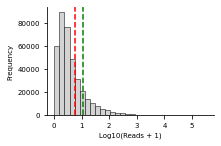

Corresponding thresholds:
3Pseq reads >= 5 :  104,994 (27.46%)
3Pseq reads >= 10:   63,199 (16.53%)


In [12]:
fig,ax = plt.subplots(1,1, figsize = (3,2))

ax.hist(np.log10(p3seq_data['reads_overall']+1), bins = 30, **barplot_format)

ax.axvline(x = np.log10(5+1), color = 'red', linestyle = 'dashed')
ax.axvline(x = np.log10(10+1), color = 'green', linestyle = 'dashed')

ax.set_xlabel("Log10(Reads + 1)")
ax.set_ylabel("Frequency")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("Corresponding thresholds:")
print(f"3Pseq reads >= 5 : {(p3seq_data['reads_overall'] >= 5).sum():8,d} ({(p3seq_data['reads_overall'] >= 5).astype(int).mean():.02%})", )
print(f"3Pseq reads >= 10: {(p3seq_data['reads_overall'] >= 10).sum():8,d} ({(p3seq_data['reads_overall'] >= 10).astype(int).mean():.02%})", )


#### Predictions by 3'READS model

In [13]:
p3seq_preds = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_external_data_predictions.scer_3Pseq_reads10.pred_by_scer_bagging3models.txt'), sep = "\t")
print(f"Input sites:\n\t{p3seq_preds.shape[0]}")

p3seq_preds.loc[p3seq_preds['supporting_reads'] >  0, 'obs_class'] = 1
p3seq_preds.loc[p3seq_preds['supporting_reads'] == 0, 'obs_class'] = 0
print(f"By class:\n\t{p3seq_preds['obs_class'].value_counts().to_dict()}")

p3seq_all_auroc, p3seq_all_auprc = models.calculate_auc(p3seq_preds['obs_class'], p3seq_preds['classification'])
print(f"Performance:\n\tAUROC={p3seq_all_auroc:.06f}\n\tAUPRC={p3seq_all_auprc:.06f}")


Input sites:
	31616
By class:
	{0.0: 15808, 1.0: 15808}
Performance:
	AUROC=0.993639
	AUPRC=0.993692


In [14]:
p3seq_preds = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_external_data_predictions.scer_3Pseq_reads10.pred_by_scer_bagging3models.txt'), sep = "\t")
print(f"Input sites:\n\t{p3seq_preds.shape[0]}")

p3seq_preds.loc[p3seq_preds['supporting_reads'] >  0, 'obs_class'] = 1
p3seq_preds.loc[p3seq_preds['supporting_reads'] == 0, 'obs_class'] = 0

p3seq_test_pos = p3seq_preds.loc[(p3seq_preds['obs_class'] == 1) & (p3seq_preds['gene'].isin(test_genes))].copy()
p3seq_test_neg = p3seq_preds.loc[(p3seq_preds['obs_class'] == 0)].sample(n = len(p3seq_test_pos), random_state = 12345).copy()
p3seq_test = pd.concat([p3seq_test_pos, p3seq_test_neg], ignore_index = True, sort = False)
print(f"By class:\n\t{p3seq_test['obs_class'].value_counts().to_dict()}")

p3seq_test_auroc, p3seq_test_auprc = models.calculate_auc(p3seq_test['obs_class'], p3seq_test['classification'])
print(f"Performance:\n\tAUROC={p3seq_test_auroc:.06f}\n\tAUPRC={p3seq_test_auprc:.06f}")


Input sites:
	31616
By class:
	{0.0: 25, 1.0: 25}
Performance:
	AUROC=0.998400
	AUPRC=0.998431


### Helicos sequencing data from Guillaume Chanfreau's lab

In [15]:
helicos_data = pd.read_csv(os.path.join(PROJECT, "saccharomyces_cerevisiae_Helicos/data/data_preparation/relative_usage/redistA.no_clustered.wild_type.tf_0.00.ru_0.02.reads_10.clusters_rudesc_alltissue.txt"), sep = "\t")
print(helicos_data.shape)


(668925, 6)


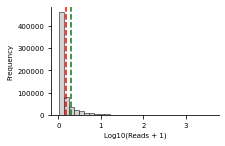

Corresponding thresholds:
Helicos RPM >= 0.5:  162,849 (24.34%)
Helicos RPM >= 1.0:  107,093 (16.01%)


In [16]:
fig,ax = plt.subplots(1,1, figsize = (3,2))

ax.hist(np.log10(helicos_data['reads_overall']+1), bins = 30, **barplot_format)

ax.axvline(x = np.log10(0.5+1), color = 'red', linestyle = 'dashed')
ax.axvline(x = np.log10(1.0+1), color = 'green', linestyle = 'dashed')

ax.set_xlabel("Log10(Reads + 1)")
ax.set_ylabel("Frequency")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("Corresponding thresholds:")
print(f"Helicos RPM >= 0.5: {(helicos_data['reads_overall'] >= 0.5).sum():8,d} ({(helicos_data['reads_overall'] >= 0.5).astype(int).mean():.02%})")
print(f"Helicos RPM >= 1.0: {(helicos_data['reads_overall'] >= 1).sum():8,d} ({(helicos_data['reads_overall'] >= 1).astype(int).mean():.02%})")


#### Predictions by 3'READS model

In [17]:
helicos_preds = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_external_data_predictions.scer_Helicos_reads1.pred_by_scer_bagging3models.txt'), sep = "\t")
print(f"Input sites:\n\t{helicos_preds.shape[0]}")

helicos_preds.loc[helicos_preds['supporting_reads'] >  0, 'obs_class'] = 1
helicos_preds.loc[helicos_preds['supporting_reads'] == 0, 'obs_class'] = 0
print(f"By class:\n\t{helicos_preds['obs_class'].value_counts().to_dict()}")

helicos_all_auroc, helicos_all_auprc = models.calculate_auc(helicos_preds['obs_class'], helicos_preds['classification'])
print(f"Performance:\n\tAUROC={helicos_all_auroc:.06f}\n\tAUPRC={helicos_all_auprc:.06f}")


Input sites:
	42012
By class:
	{0.0: 21006, 1.0: 21006}
Performance:
	AUROC=0.994469
	AUPRC=0.994812


In [18]:
helicos_preds = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_external_data_predictions.scer_Helicos_reads1.pred_by_scer_bagging3models.txt'), sep = "\t")
print(f"Input sites:\n\t{helicos_preds.shape[0]}")

helicos_preds.loc[helicos_preds['supporting_reads'] >  0, 'obs_class'] = 1
helicos_preds.loc[helicos_preds['supporting_reads'] == 0, 'obs_class'] = 0

helicos_test_pos = helicos_preds.loc[(helicos_preds['obs_class'] == 1) & (helicos_preds['gene'].isin(test_genes))].copy()
helicos_test_neg = helicos_preds.loc[(helicos_preds['obs_class'] == 0)].sample(n = len(helicos_test_pos), random_state = 12345).copy()
helicos_test = pd.concat([helicos_test_pos, helicos_test_neg], ignore_index = True, sort = False)
print(f"By class:\n\t{helicos_test['obs_class'].value_counts().to_dict()}")

helicos_test_auroc, helicos_test_auprc = models.calculate_auc(helicos_test['obs_class'], helicos_test['classification'])
print(f"Performance:\n\tAUROC={helicos_test_auroc:.06f}\n\tAUPRC={helicos_test_auprc:.06f}")


Input sites:
	42012
By class:
	{0.0: 42, 1.0: 42}
Performance:
	AUROC=0.998299
	AUPRC=0.998395


### Combined plots

In [19]:
combined_data = pd.DataFrame.from_dict({
    'data_type' : ["3P-seq","Helicos"],
    'auroc'     : [p3seq_all_auroc, helicos_all_auroc],
    'auprc'     : [p3seq_all_auprc, helicos_all_auprc],
}, orient = 'columns')

print(combined_data)


  data_type     auroc     auprc
0    3P-seq  0.993639  0.993692
1   Helicos  0.994469  0.994812


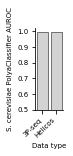

In [20]:
fig,ax = plt.subplots(1,1, figsize = (0.3+(0.1*len(combined_data)),1.5))

sns.barplot(data = combined_data, x = 'data_type', y = 'auroc', **barplot_format, ax = ax)

ax.set_xlabel("Data type")
ax.set_ylabel("S. cerevisiae PolyaClassifier AUROC")

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1.02)
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'external_data.auroc.svg'), format = 'svg', dpi = 600)
plt.show()


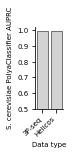

In [21]:
fig,ax = plt.subplots(1,1, figsize = (0.3+(0.1*len(combined_data)),1.5))

sns.barplot(data = combined_data, x = 'data_type', y = 'auprc', **barplot_format, ax = ax)

ax.set_xlabel("Data type")
ax.set_ylabel("S. cerevisiae PolyaClassifier AUPRC")

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(0.5,1.02)
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'external_data.auprc.svg'), format = 'svg', dpi = 600)
plt.show()
